# CNN Model with Transfer learning w/ vgg16

## Import Libraries

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

import csv
import random
import pickle

## Load downsampled dataset

In [24]:
# Load the compressed array from disk
images_mini_norm = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

In [25]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [26]:
print('images_mini.shape:', images_mini_norm.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


In [27]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 255.0
Confirm min pixel value is 0: 0.0


## Visualize image transformations

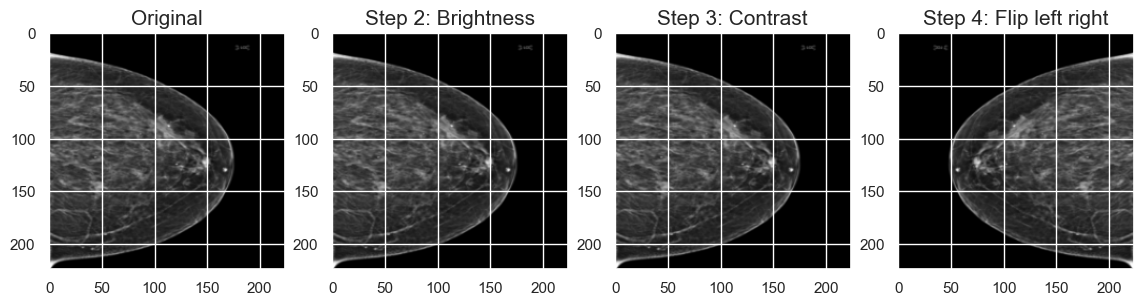

In [28]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [29]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [30]:
# Run Split train / validate / test function
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

# Print split information
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (3360, 224, 224, 3)
y_train shape (3360,)
y_train positive cases 371

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## Augmentation function

In [31]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    return X_train_augm, y_train_augm

# Run the function
X_train_augm, y_train_augm = preprocess_augm(X_train, y_train)

In [32]:
X_train_augm.shape

TensorShape([1855, 224, 224, 3])

In [33]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

## Calculate class weights function

In [34]:
def calc_class_weights(class_weight_binary, y_train):
    if class_weight_binary:
        total = len(y_train)
        pos = sum(y_train)
        neg = total - pos
        print('pos:', pos)
        print('neg:', neg)
        print('total', total)

        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weights = {0: weight_for_0, 1: weight_for_1}

        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
    else:
        class_weights = {0: 0.5, 1: 0.5}
    
    return class_weights

## Define recall, precision, f1

In [35]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Build vgg16 model function

In [36]:
import itertools

def train_test_model(params, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val):
    # Get iteration parameters from the params input
    num_units=params['num_units']
    dropout_rate = params['dropout_rate']
    optimizer = params['optimizer']
    n_epochs = params['n_epochs']
    batch_size = params['batch_size']
    class_weight_binary = params['class_weight_binary']
    pool_size = params['pool_size']
    n_augm = params['n_augm']
    
    # Define vgg16 model layers
    IMG_SIZE = 224
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    VGG16_MODEL.trainable=False
    
    # Define the other layers built on top of the vgg16 model
    global_max_layer = tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size))
    flatten_layer = tf.keras.layers.Flatten()
    extra_dense_layer = tf.keras.layers.Dense(units=num_units, activation='relu')
    dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)
    prediction_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')

    # Define the full model with vgg16 and additional layers
    model = tf.keras.Sequential([
      VGG16_MODEL,
      global_max_layer,
      flatten_layer,
      extra_dense_layer,
      dropout_layer,
      prediction_layer
    ])

    print(model.summary())

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['AUC','accuracy', recall_m, precision_m, f1_m])

    # Apply augmentations to the training group. Note number of training images is one of the parameters
    X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=n_augm)
    
    # Apply class weights. If binary is 0 -> no weights. If binary is 1 -> apply class weights
    class_weights = calc_class_weights(class_weight_binary, y_train)

    # Fit model
    history = model.fit(X_train, y_train,
                        epochs=n_epochs, 
                        validation_data=(X_val, y_val),
                        class_weight=class_weights,
                        batch_size = batch_size
                       )
    
    # Outputs
    hist = history.history
    accuracy = hist['val_accuracy'][0]
    f1 = hist['val_f1_m'][0]
    auc = hist['val_auc'][0]
    recall = hist['val_recall_m'][0]
    precision = hist['val_precision_m'][0]
    
    return [accuracy, f1, auc, recall, precision], history, model

# Define hyperparameters to use for model. 
# In this notebook, only one choice per hyperparameter since we're running the best model
param_dict = {
    'num_units': random.choice([1024]),
    'dropout_rate': random.choice([ 0.9]),
    'optimizer': random.choice(['RMSprop']),
    'n_epochs': random.choice([20]),
    'batch_size': random.choice([100]),
    'class_weight_binary': random.choice([1]),
    'pool_size': random.choice([4]),
    'n_augm': random.choice([1800])
}
print(param_dict)

# Run the model and get the results outputs for further analysis in next cells
metric_values, history, model = train_test_model(param_dict, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val)
result = [param_dict, metric_values]

{'num_units': 1024, 'dropout_rate': 0.9, 'optimizer': 'RMSprop', 'n_epochs': 20, 'batch_size': 100, 'class_weight_binary': 1, 'pool_size': 4, 'n_augm': 1800}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                            

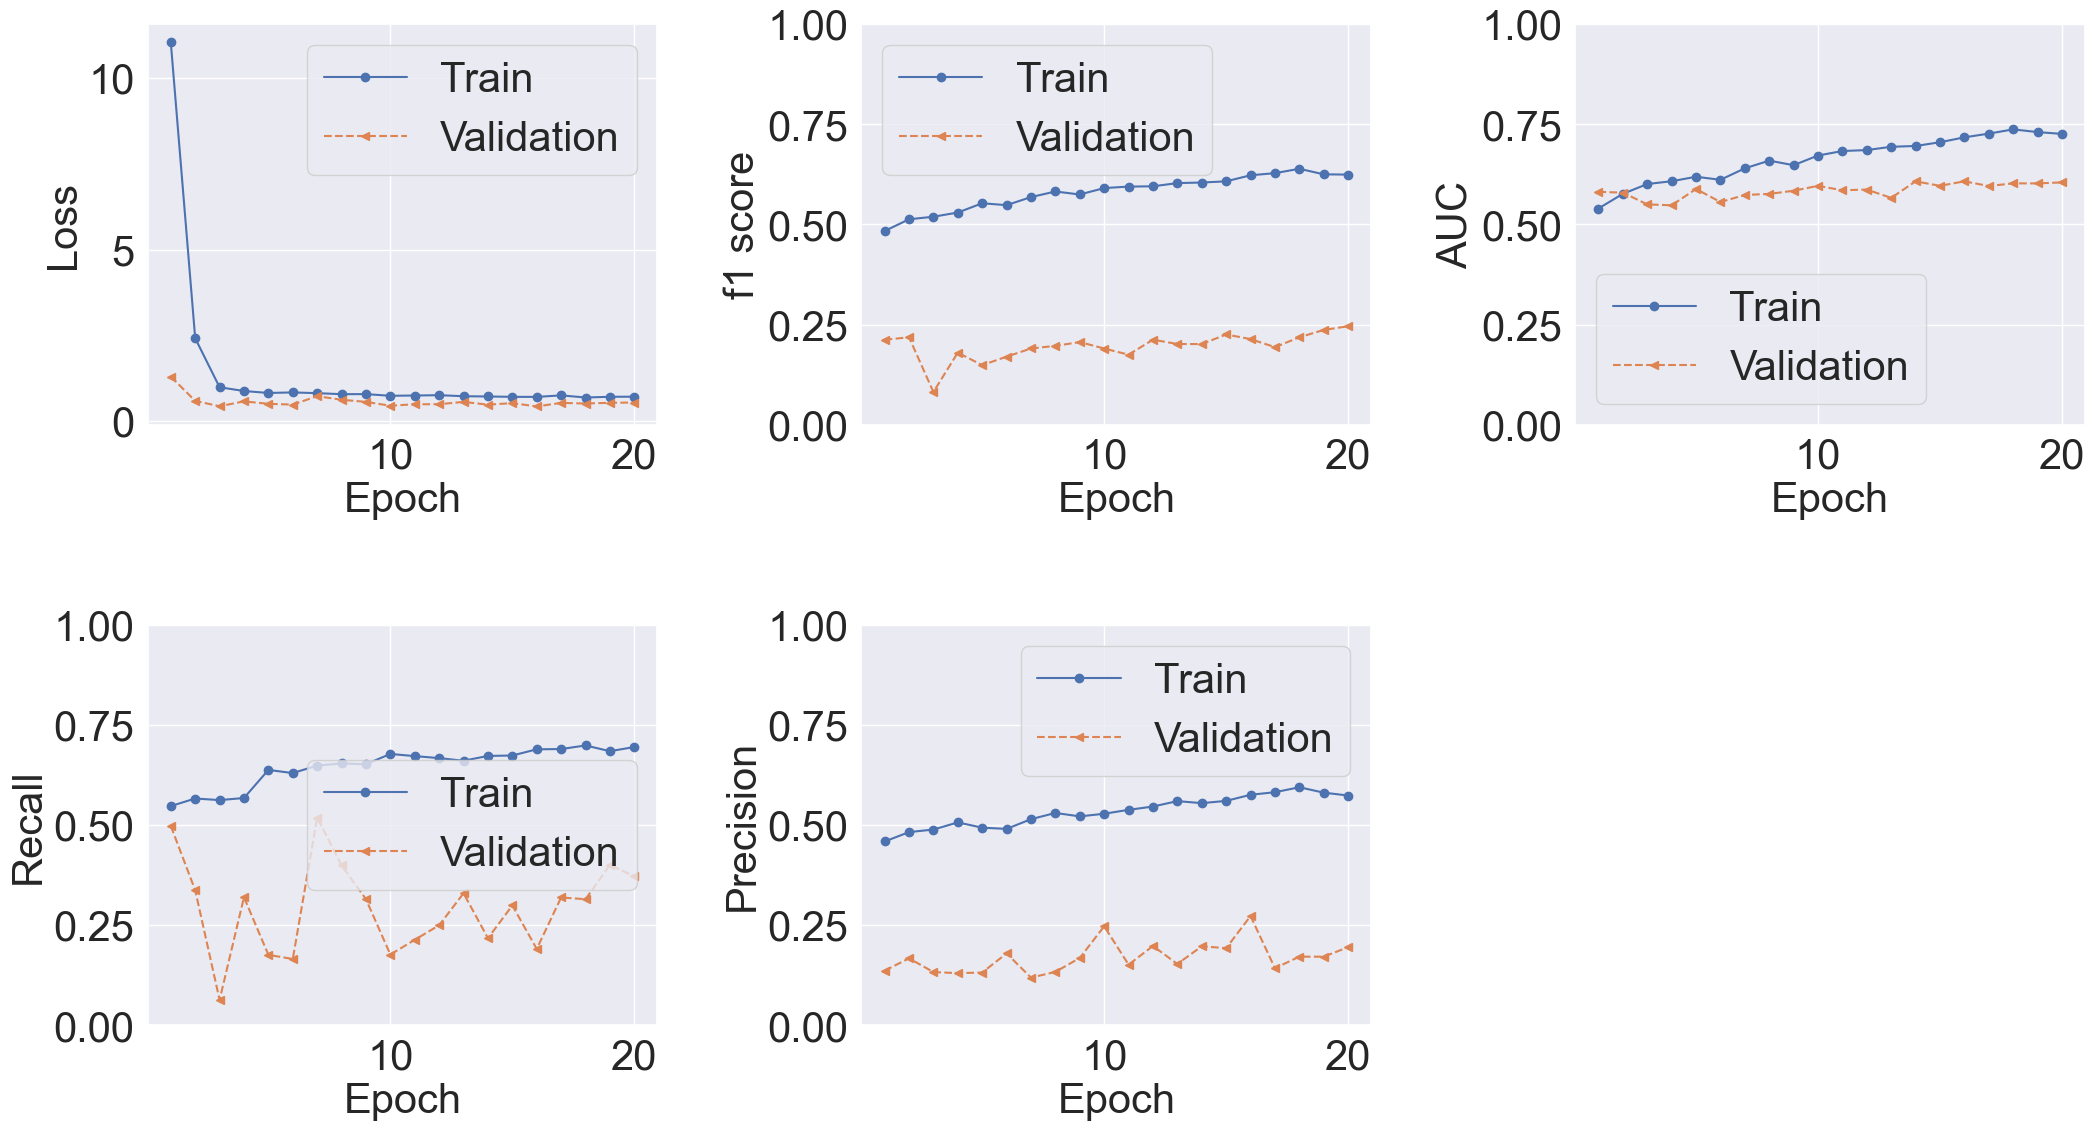

In [95]:
# Plot the metrics of interest:
# Loss, f1 score, AUC, precision, recall
font_size = 30
fig = plt.figure(figsize=(25, 13))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation')
ax.legend(fontsize=font_size)
ax.set_xlabel('Epoch', size=font_size)
ax.set_ylabel('Loss', size=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)

ax = fig.add_subplot(2, 3, 2)
ax.plot(x_arr, hist['f1_m'], '-o', label='Train')
ax.plot(x_arr, hist['val_f1_m'], '--<', label='Validation')
ax.legend(fontsize=font_size)
ax.set_xlabel('Epoch', size=font_size)
ax.set_ylabel('f1 score', size=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_ylim([0, 1])

ax = fig.add_subplot(2, 3, 3)
ax.plot(x_arr, hist['auc'], '-o', label='Train')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation')
ax.legend(fontsize=font_size)
ax.set_xlabel('Epoch', size=font_size)
ax.set_ylabel('AUC', size=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_ylim([0, 1])

ax = fig.add_subplot(2, 3, 4)
ax.plot(x_arr, hist['recall_m'], '-o', label='Train')
ax.plot(x_arr, hist['val_recall_m'], '--<', label='Validation')
ax.legend(fontsize=font_size)
ax.set_xlabel('Epoch', size=font_size)
ax.set_ylabel('Recall', size=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_ylim([0, 1])

ax = fig.add_subplot(2, 3, 5)
ax.plot(x_arr, hist['precision_m'], '-o', label='Train')
ax.plot(x_arr, hist['val_precision_m'], '--<', label='Validation')
ax.legend(fontsize=font_size)
ax.set_xlabel('Epoch', size=font_size)
ax.set_ylabel('Precision', size=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_ylim([0, 1])
#plt.show()

In [47]:
# Evaluate the model on the test set
test_results = model.evaluate(X_test, y_test)

35/35 [==============================] - 42s 1s/step - loss: 0.5403 - auc: 0.6123 - accuracy: 0.7250 - recall_m: 0.3344 - precision_m: 0.1603 - f1_m: 0.2010


In [48]:
# Make predictions on the test set
y_pred = model.predict(X_test)

35/35 [==============================] - 47s 1s/step


In [49]:
# Define threshold
threshold = 0.5

# Convert probabilities to binary classes
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

(array([216., 159., 154., 149., 137., 106.,  92.,  60.,  38.,   9.]),
 array([1.33164413e-09, 9.38539654e-02, 1.87707931e-01, 2.81561881e-01,
        3.75415862e-01, 4.69269812e-01, 5.63123763e-01, 6.56977713e-01,
        7.50831723e-01, 8.44685674e-01, 9.38539624e-01]),
 <BarContainer object of 10 artists>)

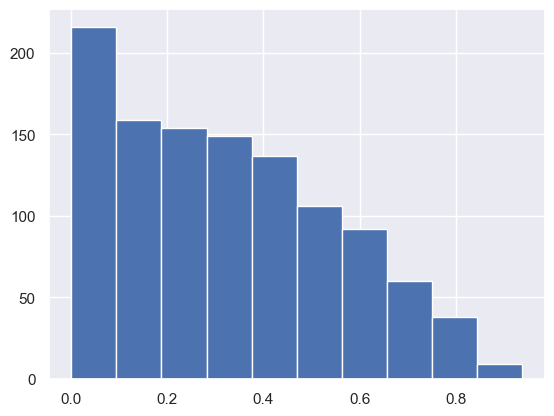

In [50]:
plt.hist(y_pred)

(array([849.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

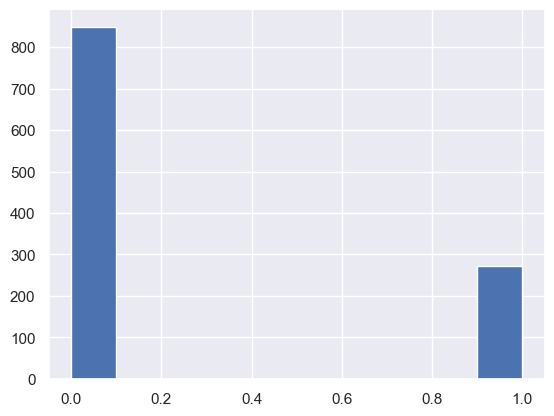

In [96]:
plt.hist(y_pred_binary)

In [97]:
# Print confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print(confusion)

[[773 232]
 [ 76  39]]


In [98]:
# Print confusion matrix details
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('true positive:', TP)
print('true negative:', TN)
print('false positive:', FP)
print('false negative:', FN)

true positive: 39
true negative: 773
false positive: 232
false negative: 76
